# 14-10. 프로젝트: 스티커를 붙여주자

# 1. 스티커 및 이미지 확인하기

In [ ]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
PROJECT_PATH = '/content/drive/MyDrive/aiffel_dataset/GD14_face_sticker/'

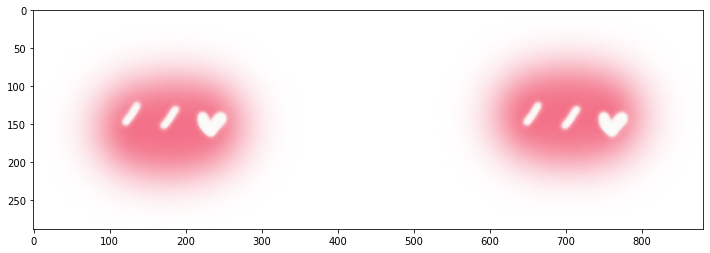

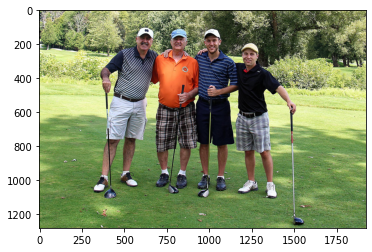

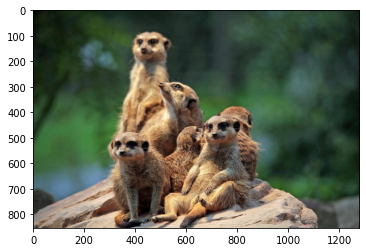

In [ ]:
image_list = ['blush.png', 'golf.jpg', 'meerkat.jpg']

plt.figure(figsize=(12, 20))
for i in image_list:
    image = Image.open(PROJECT_PATH+i)
    plt.imshow(image)
    plt.show()

스티커 사진과 적용할 단체 사진 그리고 미어켓의 얼굴도 인식을 하는지 확인하기 위해 사진을 준비했다.

# 2. SSD 모델을 통해 얼굴 bounding box 찾기

### 2-1. 데이터셋 전처리 및 분석

모델의 학습을 위해 WIDER FACE 데이터셋을 다룰 예정이다.   
YOLO, SSD 같은 single stage model을 학습시키는 것은 흔히 COCO 데이터셋이 사용되지만, 먼 거리에 있는 여러 얼굴을 detect하는 모델을 만들기 위해 넓은 공간에서 다수의 사람이 등장하는 데이터셋이 필요하다.

In [ ]:
!cd /content/drive/MyDrive/aiffel_dataset/GD14_face_sticker/widerface && ls *

wider_face_split:
readme.txt		      wider_face_train_bbx_gt.txt  wider_face_val.mat
wider_face_test_filelist.txt  wider_face_train.mat
wider_face_test.mat	      wider_face_val_bbx_gt.txt

WIDER_test:
images

WIDER_train:
images

WIDER_val:
images


WIDER_test, train, val 디렉토리는 입력용 이미지 파일만 들어와 있다.   
wider_face_split 디랙토리 내에 wider_face_train_bbx_gt.txt와 wider_face_val_bbx_gt.txt 파일 안에 포함되어 있는 bounding box 정보를 알아보자.

In [ ]:
!cd /content/drive/MyDrive/aiffel_dataset/GD14_face_sticker/widerface/wider_face_split/ && head -20 wider_face_train_bbx_gt.txt

0--Parade/0_Parade_marchingband_1_849.jpg
1
449 330 122 149 0 0 0 0 0 0 
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
389 281 17 19 2 0 0 0 2 0 
406 293 21 21 2 0 1 0 0 0 


이는 다음과 같은 반복 구조로 이루어져 있음을 파악할 수 있다.

```
# 이미지 파일 경로
0--Parade/0_Parade_marchingband_1_849.jpg
# face bounding box 개수
1
# face bounding box 좌표 등 상세정보
449 330 122 149 0 0 0 0 0 0 
```

10개의 숫자로 이루어진 정보들은 다음과 같은 상세정보를 갖고 있다.   
```
x0, y0, w, h, blur, expression, illumination, invalid, occlusion, pose
```

bounding box와 관련해서 가장 중요한 4개의 숫자는 왼쪽의 4개(X좌표, Y좌표, 너비, 높이)이다.

In [ ]:
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

bounding box 파일을 분석해보자.

In [ ]:
def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

In [ ]:
def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()
        while line:
            n_object = int(fp.readline())
            boxes = []
            for i in range(n_object):
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))
            line = fp.readline()
    return infos

위 함수는 이미지별 bounding box 정보를 `wider_face_train_bbx_gt.txt`에서 파싱해서 리스트로 추출하는 것이다.

추출한 정보를 실제 이미지 정보와 결합해보자.   
bounding box 정보는 [x, y, w, h] 형태로 저장되어 있는데, [x_min, y_min, x_max, y_max] 형태의 꼭짓점 좌표 정보로 변환해야한다.

이렇게 정보를 결합해야 나중에 학습에 용이하다.

In [ ]:
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        return 1, image_string, None

In [ ]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

이렇게 결합된 데이터의 형태를 5개만 확인해보자.   
그리고 이 정보를 활용하여 텐서플로우 데이터셋을 생성해보자.

In [ ]:
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')
for i, info in enumerate(parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/content/drive/MyDrive/aiffel_dataset/GD14_face_sticker/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/content/drive/MyDrive/aiffel_dataset/GD14_face_sticker/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/content/drive/MyDrive/aiffel_dataset/GD14_face_sticker/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 2

### 2-2. TFRecord 생성
오늘 다루는 대용량 데이터셋의 처리속도 향상을 위해, 전처리 작업을 통해 TFRecord 데이터셋으로 변환해보자.   
TFRecord란 TensorFlow만의 학습 데이터 저장 포맷으로, 이진 레코드의 스퀀스를 저장한다. TFRecord 형태의 학습 데이터를 사용하여 모델 학습을 하면 학습 속도가 개선된다.

TFRecord는 여러 개의 tf.train.Example로 이루어져 있고, 한 개의 tf.train.Example은 여러 개의 tf.train.Feature로 이루어져 있다.

데이터 단위를 이루는 tf.train.Example 인스턴스를 생성하는 메소드를 선언해보자.

In [ ]:
def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

전처리에 필요한 함수들이 갖추어졌다.   
데이터셋의 이미지 파일, 그리고 bounding box 정보를 모아 위의 make_example 메소드를 통해 만든 example을 serialize하여 TFRecord 파일로 생성하게 된다.

In [ ]:
for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH 
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'

    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())

100%|██████████| 3226/3226 [15:06<00:00,  3.56it/s]


In [ ]:
!ls /content/drive/MyDrive/aiffel_dataset/GD14_face_sticker/dataset

train_mask.tfrecord  val_mask.tfrecord


### 2-3. SSD의 Default box 구하기
SSD 모델의 가장 중요한 특징 중 하나는 Default box를 필요로 한다는 점이다.   
Default box란, object가 존재할만한 다양한 크기의 box 좌표 및 클래스 정보를 일정 개수만큼 미리 고정해 둔 것이다. 이를 anchor box, prior box라고 부른다.   
SSD의 default box의 다른 점은 여러 층의 feature map에서 box를 만든다는 점이다. 층 수 만큼 box도 많아지고, 층마다 box의 크기도 다양해진다.   
ground truth에 해당하는 bounding box의 IoU를 계산하여 일정 크기(0.5) 이상 겹치는 default box를 선택하는 방식이 RCNN 계열의 sliding window 방식보다 훨씬 속도가 빠르면서 유사한 정확도를 얻을 수 있다.  



default box를 생성하기 위해 기준이 되는 feature map을 먼저 생성해야한다. 그림에서는 8x8, 4x4의 예가 나오지만 이번에는 4가지 유형의 feature map을 생성해보자.

In [ ]:
BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

In [ ]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

### 2-4. SSD model build
SSD 모델에서 일반적으로 많이 쓰이는 convolution block, depthwise convolution block, skip connection으로 쓰일 branch block을 준비하자.

In [ ]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

In [ ]:
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

In [ ]:
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

여러 블록을 쌓아 모델을 만든 후, 중간중간 Branch 부분에 head라고 불리는 convolution layer를 붙일것이다.   
하나의 head에 convolution layer 2개가 필요하다. 하나는 confidence를 예측하기 위해, 하나는 location을 예측하기 위해 사용한다.

branch마다 head가 연결되어 있기 때문에 모델의 중간 레이어에서도 예측을 위한 정보를 가져올 수 있다.

In [ ]:
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

In [ ]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

In [ ]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2)) # 1
    x = _conv_block(x, base_channel * 2, strides=(1, 1)) # 2
    x = _conv_block(x, base_channel * 2, strides=(2, 2)) # 3
    x = _conv_block(x, base_channel * 2, strides=(1, 1)) # 4
    x = _conv_block(x, base_channel * 4, strides=(2, 2)) # 5
    x = _conv_block(x, base_channel * 4, strides=(1, 1)) # 6
    x = _conv_block(x, base_channel * 4, strides=(1, 1)) # 7
    x = _conv_block(x, base_channel * 4, strides=(1, 1)) # 8
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2)) # 9
    x = _conv_block(x, base_channel * 8, strides=(1, 1)) # 10
    x = _conv_block(x, base_channel * 8, strides=(1, 1)) # 11
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2)) # 12
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1)) # 13
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2)) # 14
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

In [ ]:
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_pad_1 (ZeroPadding2D)     (None, 258, 322, 3)  0           ['input_image[0][0]']            
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 160, 16  432         ['conv_pad_1[0][0]']             
                                )                                                                 
                                                         

### 2-5. 모델 학습 Augmentation, IoU 적용하기

Augmentation 적용하기

TFRecord 형태의 데이터셋은 아직 data augmentation이 적용되지 않았다. object detection에 사용되는 다양한 augmentation 기법을 적용해주자.   
`tf.data.TFRcordDataset.map()` 내에서 호출할 메소드들을 알아보자.   
- `_crop`, `_pad_to_square`, `_resize`, `_flip`, `_distort`

Image Classification에서 사용하던 함수와 비교적 복잡한 함수들이다. 이미지가 변경되면서 box의 위치나 크기도 함께 변경되어야 하기 때문에 복잡해질 수 밖에 없다.

In [ ]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

In [ ]:
def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            # size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

In [ ]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

In [ ]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img

In [ ]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

`_crop` 했을 때 box도 함께 잘릴 수 있으므로 신경써야한다.   
`_resize`, `_flip`도 box에 영향을 끼친다.

`_pad_to_square`은 이미지가 정사각형이 되도록 이미지 오른쪽이나 아래 방향으로 평균 색상 영역을 추가하는 작업이다. 이는 box 정보는 변하지 않는다.   
`_distort`도 이미지 색상 값만 바꿔주어 box 정보를 바꿀 필요가 없다.

In [ ]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

Default box의 IoU 적용하기

SSD 모델의 특징 중 하나가 default box를 사용한다는 점이다. default box 정보는 데이터셋에 반영되어야 한다.   
default box와 bounding box 사이의 IoU, 다른 말로 자카드 유사도(jaccar index)를 측정하기 위한 메소드들을 알아보자.

자카드 유사도란 두 집합을 통해 유사도를 측정하는 방법 중 하나로, 두 집합의 교집합을 두 집합의 합집합으로 나눈다. 그래서 유사도는 0~1 사이의 값을 가지며, 서로 비슷할수록 1에 근접하다.

In [ ]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

In [ ]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

이렇게 IoU(자카드 유사도)를 계산하는 메소드가 준비됐다. TFRecord 데이터셋의 라벨을 가공하는 메소드를 만들어보자.

- jaccard 메소드를 이용해 label의 ground truth bbox와 가장 overlap 비율이 높은 matched box를 구한다.
- `_encode_bbox` 메소드를 통해 bbox의 scale을 동일하게 보정한다.
- 전체 default box에 대해 일정 threshold 이상 overlap되는 ground truth bounding box 존재 여부를 concat하여 새로운 label로 업데이트한다.

In [ ]:
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)

In [ ]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

load_dataset

위에서 구현한 augmentation, IoU 메소드를 tfrecord 데이터셋에 적용하여 SSD 학습을 위한 데이터셋을 생성하는 최종 메소드 `load_dataset`을 구현하자.
- `_transform_data`: augmentation, label을 encoding하여 기존의 dataset을 변환하는 메소드
- `_parse_tfrecord`: TFRecord에 `_transform_data`를 적용하는 함수 클로저 생성
- `load_tfrecord_dataset`: `tf.data.TFRecordDataset.map()`에 `_parse_tfrecord`를 적용하는 실제 데이터셋 변환 메인 메소드
- `load_dataset`: `load_tfrecord_dataset`을 통해 train, validation 데이터셋을 생성하는 최종 메소드

In [ ]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data

In [ ]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

In [ ]:
def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset

### 2-6. 모델 train

Learning rate scheduler

learning rate를 조정해야한다.   
초기시점에 warmup 부분을 도입해 learning rate가 천천히 증가할 수 있도록 학습 스텝에 따라 다른 learning rate를 적용해야한다.   

In [ ]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

In [ ]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

Hard negative mining

Object detection 모델 학습할 때 hard negative mining이라고 자주 사용되는 기법이 있다. 학습 과정에서 label은 negative인데 confidence가 높게 나오는 샘플을 재학습하면 positive와 negative가 모호한 경계선상에 분포하는 false negative 오류에 강해진다는 장점이 있다.   
실제로 confidence가 높은 샘플을 모아 training을 다시 수행하기보다, 그런 샘플들에 대한 loss만 따로 모아 계산해주는 방식으로 반영할 수 있다.

object detection에서는 물체 영역보다 배경 영역이 많은 경우가 빈번하므로 negative 비율을 positive의 3배가 되도록 설정했다.

In [ ]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

In [ ]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

이렇게 구현한 `hard_negative_mining` 메소드를 통해 얻은 샘플의 localization loss를 기존의 classification loss에 추가로 반영하는 `MultiBoxLoss` 계산 메소드이다.

__Training__

모델 학습을 진행해보자.   
default box를 만들고 데이터셋을 준비하자

In [ ]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)

Model: "ssd_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_pad_15 (ZeroPadding2D)    (None, 258, 322, 3)  0           ['input_image[0][0]']            
                                                                                                  
 conv_15 (Conv2D)               (None, 128, 160, 16  432         ['conv_pad_15[0][0]']            
                                )                                                                 
                                                                                          

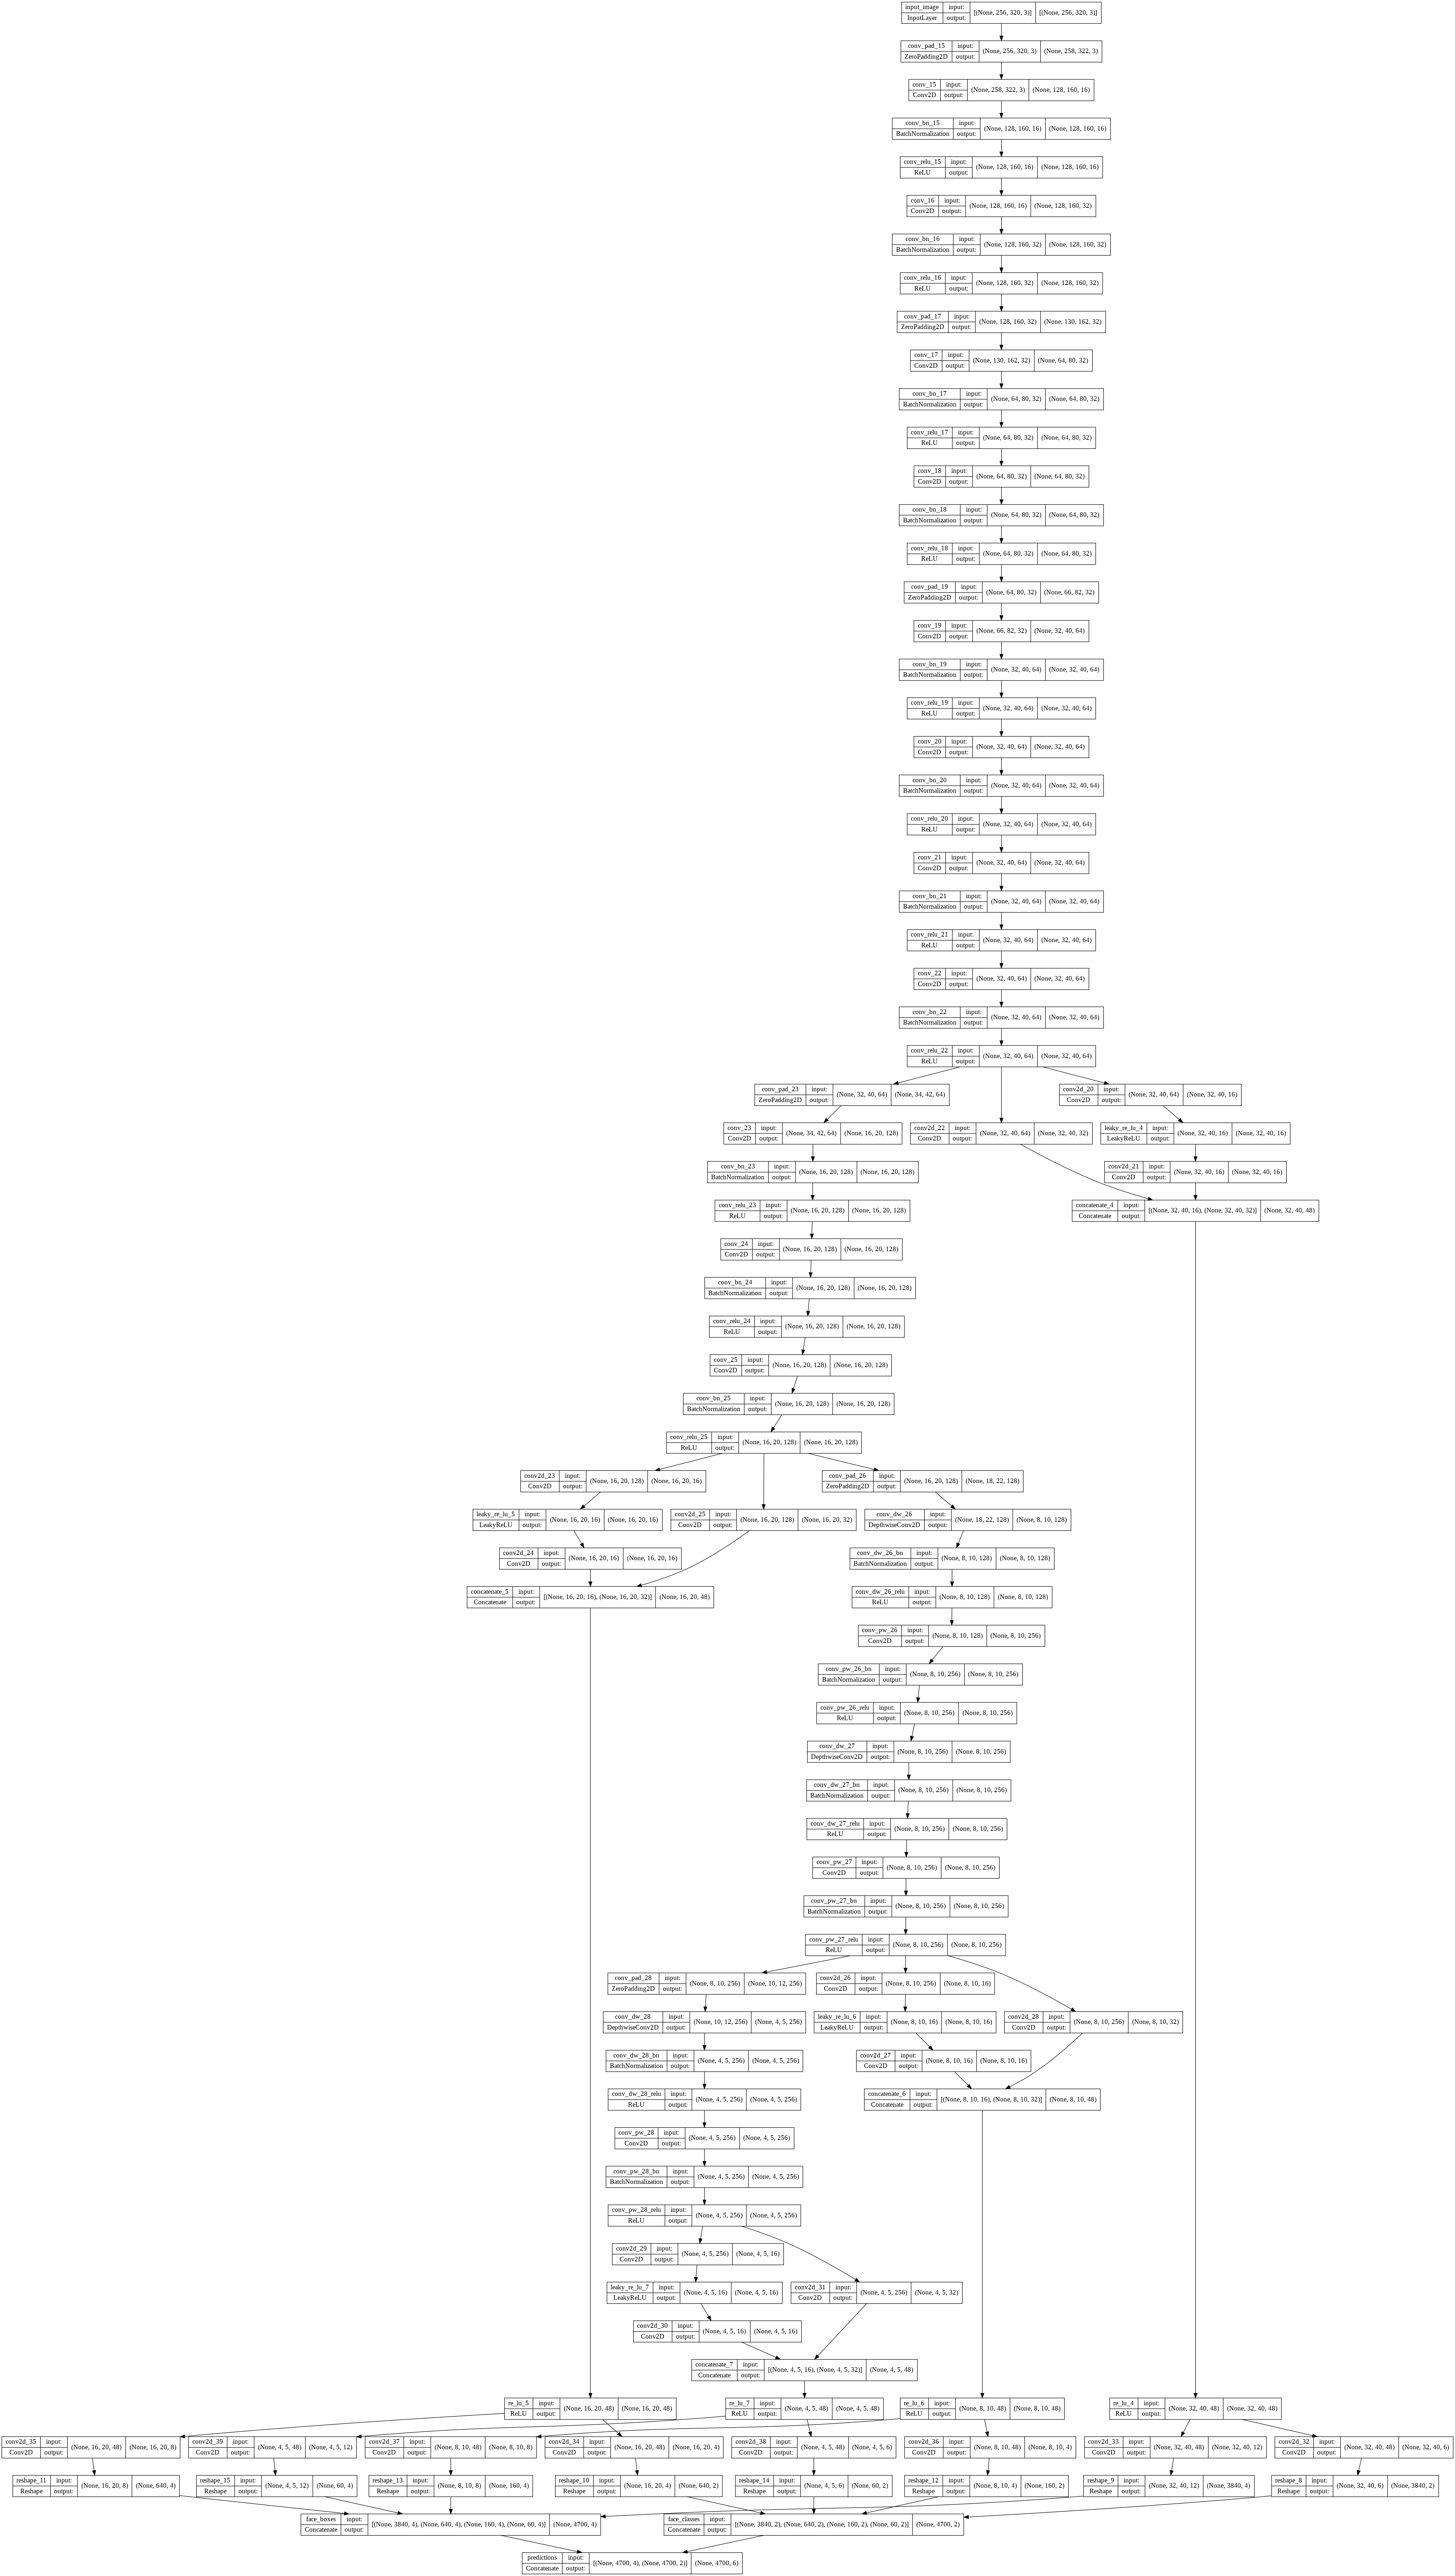

In [ ]:
model = SsdModel()
model.summary()
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(os.getcwd(), 'model.png'),
    show_shapes=True, 
    show_layer_names=True
)

In [ ]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

학습이 진행될 함수를 작성할 차례이다.   
`tf.GradientTape()`를 사용한다.   
- [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)

In [ ]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

위는 한 스텝이 학습되는 함수이다.

본격적으로 train을 시작해보자. 100 epochs 이상 학습시켜야 좋은 성능을 보인다.

In [ ]:
# 100 에포크까지 학습을 진행했다. 해당 체크포인트를 이용해서 진행해보자.

# EPOCHS = 100

# for epoch in range(0, EPOCHS):
#     for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
#         load_t0 = time.time()
#         total_loss, losses = train_step(inputs, labels)
#         load_t1 = time.time()
#         batch_time = load_t1 - load_t0
#         print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

#     filepath = os.path.join(CHECKPOINT_PATH, f'weights_epoch_{(epoch + 1):03d}.h5')
#     model.save_weights(filepath)

In [ ]:
# 100 에포크로 디텍을 진행해봤지만 결과가 깔끔하지 않아서 150까지 진행해보자.
model.load_weights('/content/drive/MyDrive/aiffel_dataset/GD14_face_sticker/checkpoints/weights_epoch_100.h5')

EPOCHS = 150

for epoch in range(101, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

    filepath = os.path.join(CHECKPOINT_PATH, f'weights_epoch_{(epoch + 1):03d}.h5')
    model.save_weights(filepath)

Epoch: 150/150 | Batch 402/402 | Batch time 0.048 || Loss: 5.479285 | loc loss:4.358479 | class loss:1.120806 

### 2-7. NMS 구현하기
Grid cell을 사용하는 object detection의 inference 단계에서 하나의 object가 여러 개의 default box에 걸쳐져 있을 때 IoU가 가장 높은 default box를 선택하는 NMS(non-max suppression)이 필요하다.

In [ ]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

NMS를 통해 겹쳐진 bbox를 하나로 줄일 수 있게 되었다.   
이제 모델의 예측 결과를 해석해주는 함수를 작성해보자.

아래 함수는 모델의 예측 결과를 디코딩해서 예측 확률을 토대로 NMS를 통해 최종 box와 score 결과를 만들어 준다.

In [ ]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

In [ ]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

### 2-8. face detection
SSD 모델을 통해 Multi-face detection 기능을 추가했다. 이를 테스트해보자.

우선 입력 이미지의 비율이 달라도 모델이 작동할 수 있도록 이미지 패딩을 추가, 제거해주는 함수를 만들자

그리고 최종 결과를 시각화 할 수 있도록 이미지에 box를 그리고 확률도 함께 표시해주자.

In [ ]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

In [ ]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

In [ ]:
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

이미지를 테스트해보자.

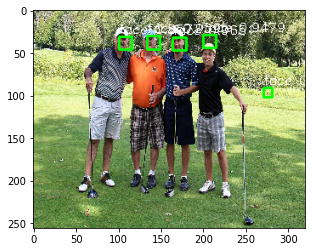

In [ ]:
filepath = '/content/drive/MyDrive/aiffel_dataset/GD14_face_sticker/checkpoints/weights_epoch_150.h5'
model.load_weights(filepath)

def detect_face(IMAGE_PATH):
    img_raw = cv2.imread(IMAGE_PATH)
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = np.float32(img_raw.copy())

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
    img = img / 255.0

    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)

    predictions = model.predict(img[np.newaxis, ...])

    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)

    for box_index in range(len(pred_boxes)):
        draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.show()

golf_image_path = os.path.join(PROJECT_PATH, 'golf.jpg')
detect_face(golf_image_path)

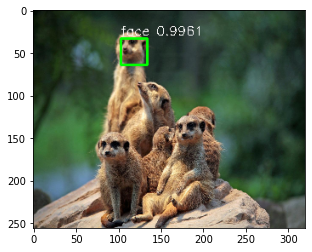

In [ ]:
meerkat_image_path = os.path.join(PROJECT_PATH, 'meerkat.jpg')
detect_face(meerkat_image_path)

# 3. 스티커 합성 사진 생성하기

(288, 881, 3)


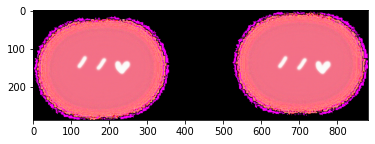

In [ ]:
STICKER_PATH = '/content/drive/MyDrive/aiffel_dataset/GD14_face_sticker/blush.png'
# img_sticker = cv2.imread(STICKER_PATH, cv2.IMREAD_UNCHANGED)
img_sticker = cv2.imread(STICKER_PATH)
print(img_sticker.shape)
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
def sticker_on_face(img, boxes, box_index, sticker):
    img_height = img.shape[0]
    img_width = img.shape[1]
    sticker_width = sticker.shape[0]
    sticker_height = sticker.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    # # sticker의 width가 box 사이즈에 맞춰 줄어드는 비율만큼 height 사이즈 조절
    # resize_sticker_per = (x_max-x_min) / sticker_width
    # sticker_width = sticker_width * resize_sticker_per
    # sticker_width = round(sticker_width) # 소수점 -> 정수
    # sticker_height = sticker_height * resize_sticker_per
    # sticker_height = round(sticker_height) # 소수점 -> 정수

    sticker_width = x_max - x_min
    sticker_height = sticker_width//2
    
    sticker = cv2.resize(sticker, (sticker_width, sticker_height))
    print(sticker.shape, sticker_width, sticker_height)
    print(img.shape)

    sticker_area = img[y_min:y_min+sticker_height, x_min:x_min+sticker_width]

    img[y_min:y_min+sticker_height, x_min:x_min+sticker_width] = \
    np.where(sticker==255,sticker_area,sticker).astype(np.uint8)

In [ ]:
def detect_sticker_on_face(IMAGE_PATH):
    img_raw = cv2.imread(IMAGE_PATH)
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = np.float32(img_raw.copy())

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
    img = img / 255.0

    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)

    predictions = model.predict(img[np.newaxis, ...])

    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)

    for box_index in range(len(pred_boxes)):
        # draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)
        sticker_on_face(img_raw, pred_boxes, box_index, img_sticker)

    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.show()

(8, 16, 3) 16 8
(256, 320, 3)
(7, 15, 3) 15 7
(256, 320, 3)
(7, 15, 3) 15 7
(256, 320, 3)
(7, 15, 3) 15 7
(256, 320, 3)
(5, 10, 3) 10 5
(256, 320, 3)


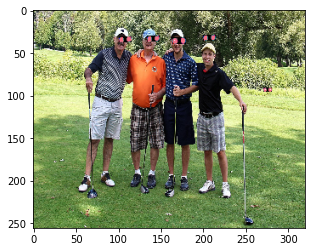

In [ ]:
detect_sticker_on_face(golf_image_path)

(15, 31, 3) 31 15
(256, 320, 3)


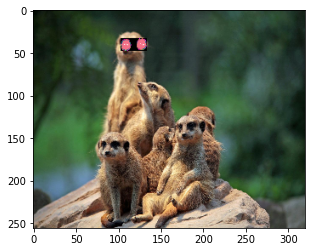

In [ ]:
detect_sticker_on_face(meerkat_image_path)

# 회고

얼굴의 landmark를 찾기 위해 dlib을 사용하는 선택사항이 있었는데, dlib를 사용하려다 실패했다. 익스 3번 face sticker를 보면 해당 dlib 데이터셋을 가져와서 detect과정에 bbox, landmark 작업을 같이 하고 있어서 landmark 부분만 따로 빼내서 작업하기 어려웠다.   
그래서 결국 bbox를 그리기 대신 sticker를 bbox에 맞춰 resize하고 적용하는 방식을 택했다.

LMS에서 SSD 모델이 100 에포크 정도면 괜찮다고 써있는데, 실제로 적용 해봤을때 결과물이 별로였다. 그리고 주위 동료들의 얘기를 들어봐도 150 에포크 정도는 되어야 하는거 같다. 그래서 다시 학습을 진행했고 스티커를 적용했다.

모델의 교체로 detection 성능 상승이 체감되지 않아서 아쉽다. 1-stage 방식이라 더더욱 그렇겠지만 이러한 경우에는 이미지가 아닌 영상의 인식이였음 어땠을까 싶다.

그리고 cv2에서 png 파일의 배경을 날려서 가져오려면   
```
img_sticker = cv2.imread(STICKER_PATH) ->
img_sticker = cv2.imread(STICKER_PATH, cv2.IMREAD_UNCHANGED)
```
방식으로 가져와야한다. 하지만 이렇게 가져오면 채널값이 하나 늘어나서 합성이 제대로 안된다. jpg 배경에 png 사진을 넣어서 그런가..? 시간이 없어서 제대로 해결을 못했다.   

최종 결과도 아쉽게 나왔다. 단체사진도 detection을 제대로 못했고 미어캣도 한 마리만 인식했다. 모델이 인식하기 어려운 이미지를 사용해서 그런거 같다. 누끼작업이 되어있는 사진을 선택했다면 더 깔끔한 결과가 나왔을것이다.